In [1]:
from IPython.display import Latex

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

import numpy as np

from scipy.constants import hbar, e, physical_constants
from scipy.optimize import curve_fit
from scipy.special import spherical_jn, spherical_yn

from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('H-Kr.pdf')

# 4. $\frac{\hbar^2}{2 \mu}$ in problem units

In [2]:
m_Kr = 83.798 * physical_constants['atomic mass constant'][0]
m_H = 1.00797 * physical_constants['atomic mass constant'][0]
mu = m_Kr*m_H / (m_Kr + m_H)

In [3]:
epsilon = 5.9 # meV
sigma = 3.18 # Å

Rmax = 25

# alpha = 2m / hbar^2
alpha = 2 * mu / hbar**2 * sigma**2*1e-20 * epsilon*1e-3*e
display(Latex(f'$\\frac{{\\hbar^2}}{{2 \\mu}} = {1 / alpha:.4f}$'))

# Lennard-Jones potential combined with centrifugal potential
def Veff_lj(r, l):
    return 4*alpha*((1/r)**12 - (1/r)**6) + l*(l+1) / r**2

<IPython.core.display.Latex object>

# 5. $u(r)$ for $r \rightarrow 0$

In [4]:
b = (4 / 25 * alpha)**(1/10)

print(f'b = {b:.4f}')

b = 1.1636


# 6. Integral cross section

In [5]:
def u(r):
    return np.exp(- b**5 / r**5)

# minimum value for which u(r) > 0 (due to computational limitation on floating numbers)
# r_min = np.linspace(1e-2, 1, 100)[np.where(u(np.linspace(1e-2, 1, 100)) > 0)[0][0] + 3]
r_min = 0.4

def numerov(u, V, E, dr):
    # Numerov method: u and V must be lists or arrays
    k2 = E - V
    for n in range(1, len(u)-1):
        # Numerov formula
        u[n+1] = u[n]*(2-5*dr**2*k2[n]/6) - u[n-1]*(1+dr**2*k2[n-1]/12)
        u[n+1] = u[n+1] / (1 + dr**2*k2[n+1]/12)
    return u

In [6]:
def wf_scatt(e, l, rgrid):
    dr = (max(rgrid) - min(rgrid)) / len(rgrid)
    
    # boundary conditions Numerov method
    wf = np.zeros(len(rgrid))
    wf[0] = np.exp(- b**5 / rgrid[0]**5)
    wf[1] = np.exp(- b**5 / rgrid[1]**5)
    
    # compute wf with Numerov method
    wf = numerov(wf, Veff_lj(rgrid, l), e*alpha, dr)
    return wf

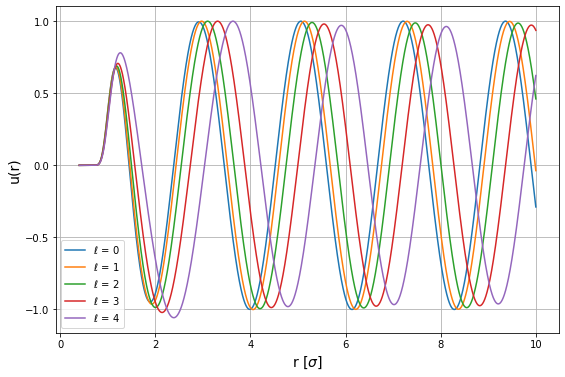

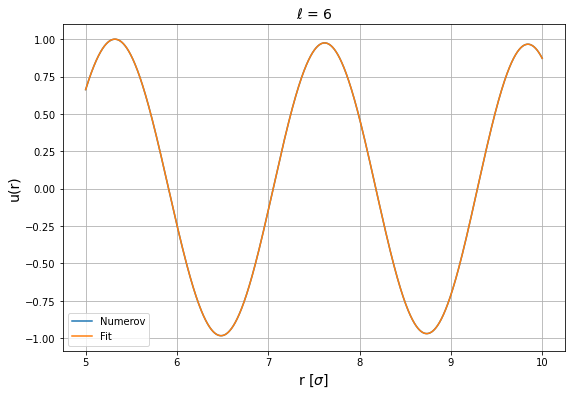

In [7]:
Rmax = 10
rgrid = np.linspace(r_min, Rmax, 10000)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

for l in range(7):
    wf = wf_scatt(E, l, rgrid)
    
    # fitting function for l
    def u_fit(r, C, delta):
        return C * r * (np.cos(delta)*spherical_jn(l, k*r) - np.sin(delta)*spherical_yn(l, k*r))
        
    if l < 5:
        plt.plot(rgrid, wf / max(wf), label=f'$\ell$ = {l}')
    
    # finding delta_l via fit
    popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
    perr = np.sqrt(np.diag(pcov))
    
    if l == 6:
        plt.xlabel("r [$\sigma$]", fontsize=14)
        plt.ylabel("u(r)", fontsize=14)
        plt.legend()
        plt.grid()
        pdf.savefig()
        plt.show()
        
        plt.plot(rgrid[rmax:], wf[rmax:] / max(wf[rmax:]), label='Numerov')
        plt.plot(rgrid[rmax:], u_fit(rgrid[rmax:], *popt) / max(wf[rmax:]), label='Fit')
        plt.title(f'$\ell$ = {l}', fontsize=14)
        plt.xlabel("r [$\sigma$]", fontsize=14)
        plt.ylabel("u(r)", fontsize=14)
        plt.legend()
        plt.grid()
        pdf.savefig()
        plt.show()

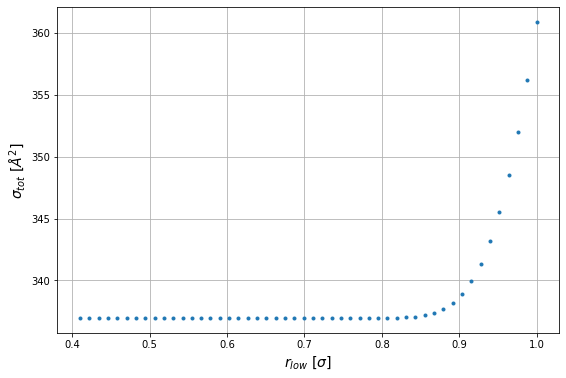

In [8]:
Rmax = 10
rgrid = np.linspace(r_min, Rmax, 10000)

cross_low = np.zeros((50, 2))
r_lows = np.linspace(r_min+1e-2, 1, 50)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

# iterate over possible values of rlow
for ind, r_low in enumerate(r_lows):
    for l in range(7):
        rgrid = np.linspace(r_low, Rmax, 10000)
        wf = wf_scatt(E, l, rgrid)
        
        # fitting function for l
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*spherical_jn(l, k*r) - np.sin(delta)*spherical_yn(l, k*r))

        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # computer cross section and its error
        cross_low[ind] += ((2*l + 1) * np.sin(popt[1])**2, abs((2*l + 1) * np.sin(2*popt[1])*perr[1]))
    cross_low[ind] *= 4 * np.pi / k**2

plt.errorbar(r_lows, cross_low[:, 0]*sigma**2, fmt='.', yerr=cross_low[:, 1]*sigma**2)
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('$r_{low}$ [$\\sigma$]', fontsize=14)
plt.grid()
pdf.savefig()
plt.show()

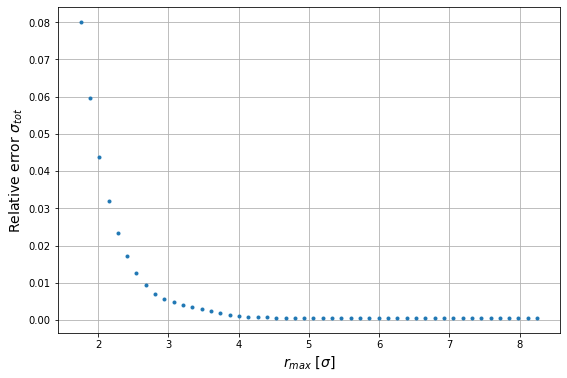

In [9]:
Rmax = 10
rgrid = np.linspace(r_min, Rmax, 10000)

cross_max = np.zeros((50, 2))
r_maxs = np.linspace(1.75, 8.25, 50)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# iterate over possible values of r_max
for ind, _r_max in enumerate(r_maxs):
    for l in range(7):
        rgrid = np.linspace(r_min, Rmax, 10000)
        wf = wf_scatt(E, l, rgrid)
        
        # obtain index for r > rmax
        rmax = np.where(rgrid > _r_max)[0][0]
        
        # fitting function for l
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*spherical_jn(l, k*r) - np.sin(delta)*spherical_yn(l, k*r))

        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # computer cross section and its error
        cross_max[ind] += ((2*l + 1) * np.sin(popt[1])**2, abs((2*l + 1) * np.sin(2*popt[1])*perr[1]))
    cross_max[ind] *= 4 * np.pi / k**2

plt.errorbar(r_maxs, cross_max[:, 1]*sigma**2/cross_max[:, 0]*sigma**2, fmt='.')#, yerr=cross_max[:, 1]*sigma**2)
plt.ylabel('Relative error $\\sigma_{tot}}$', fontsize=14)
plt.xlabel('$r_{max}$ [$\\sigma$]', fontsize=14)
plt.grid()
pdf.savefig()
plt.show()

In [10]:
l_max = 8

E = np.linspace(0.01, 3.5, 500) / epsilon
cross = np.zeros((500, l_max+1, 2))

Rmax = 25
rgrid = np.linspace(0.4, Rmax, 10000)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

# iterate over possible values of energy
for ind, e in enumerate(E):
    for l in range(l_max+1):
        # compute wave function
        wf = wf_scatt(e, l, rgrid)
        
        # fitting function for l
        k = np.sqrt(e * alpha)
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*spherical_jn(l, k*r) - np.sin(delta)*spherical_yn(l, k*r))
        
        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # compute cross section and its error
        cross[ind, l] += ((2*l + 1) * np.sin(popt[1])**2, (2*l + 1) * np.sin(2*popt[1])*perr[1])
            
    cross[ind] *= 4 * np.pi / k**2

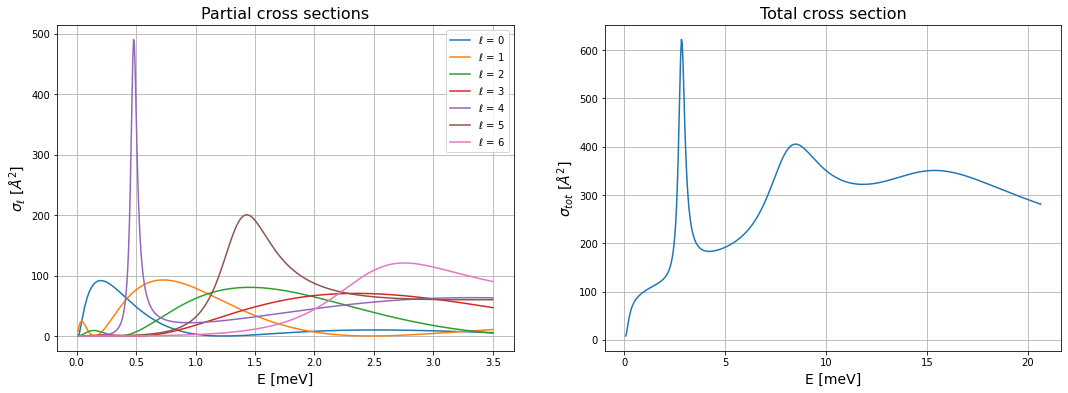

In [11]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
E = np.linspace(0.01, 3.5, 500)
for l in range(7):
    plt.plot(E, cross[:, l, 0]*sigma**2, label=f'$\ell$ = {l}')

plt.ylabel('$\\sigma_{\ell}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('E [meV]', fontsize=14)
plt.title('Partial cross sections', fontsize=16)
plt.grid()
plt.legend()

plt.subplot(122)
int_cross = np.sum(cross[:, :7, :], axis=1)
plt.errorbar(E*epsilon, int_cross[:, 0]*sigma**2)
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('E [meV]', fontsize=14)
plt.title('Total cross section', fontsize=16)
plt.grid()
pdf.savefig()
plt.show()

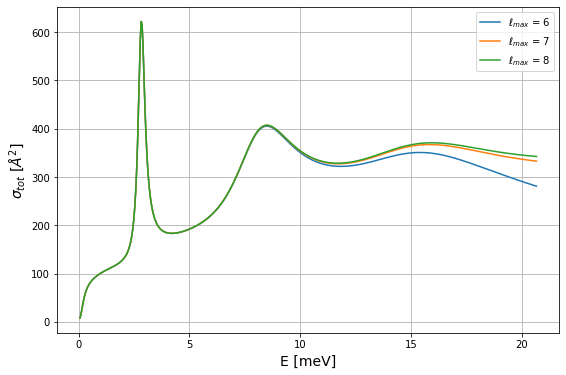

In [12]:
E = np.linspace(0.01, 3.5, 500)

for l in range(6, l_max+1):
    int_cross = np.sum(cross[:, :l+1, :], axis=1)
    plt.plot(E*epsilon, int_cross[:, 0]*sigma**2, label=f'$\ell_{{max}}$ = {l}')
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('E [meV]', fontsize=14)
plt.grid()
plt.legend()
pdf.savefig()
plt.show()

In [13]:
E = np.linspace(0.01, 3.5, 500)

# find resonant frequencies
res0 = cross[:, 4, 0].argmax()
res1 = cross[:, 5, 0].argmax()
res2 = cross[:, 6, 0].argmax()

dE = (E[1] - E[0])*epsilon
display(Latex(f'$E_{{res}}^4 = ({E[res0]*epsilon:.3f} \pm {dE:.3f})$ meV'))
display(Latex(f'$E_{{res}}^5 = ({E[res1]*epsilon:.3f} \pm {dE:.3f})$ meV'))
display(Latex(f'$E_{{res}}^6 = ({E[res2]*epsilon:.3f} \pm {dE:.3f})$ meV'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

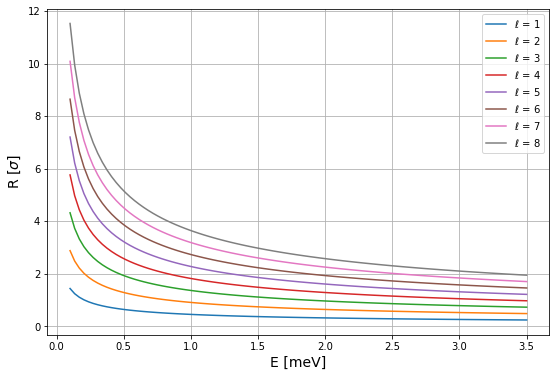

In [14]:
R = np.zeros((9,100))
E = np.linspace(0.1, 3.5, 100) / epsilon

for ind, e in enumerate(E):
    R[:, ind] = [l / np.sqrt(e * alpha) for l in range(9)]

for l in range(1, 9):
    plt.plot(E*epsilon, R[l, :], label=f'$\ell$ = {l}')

plt.xlabel('E [meV]', fontsize=14)
plt.ylabel('R [$\sigma$]', fontsize=14)
plt.legend()
plt.grid()
pdf.savefig()
plt.show()

In [15]:
pdf.close()